## Enhancing Anomaly Detection Methods for Energy Time Series Using Latent Space Data Representations
This notebook contains code to replicate the results of the non-sequential machine learning pipeline demonstrated at deRSE-2023 for enhancing anomaly detection. This code is based on the following paper:
>M. Turowski, B. Heidrich, K. Phipps, K. Schmieder, O. Neumann, R. Mikut, and V. Hagenmeyer, 2022, "Enhancing Anomaly Detection Methods for Energy Time Series Using Latent Space Data Representations," in The Thirteenth ACM International Conference on Future Energy Systems (e-Energy ’22). ACM, pp. 208–227. doi: [10.1145/3538637.3538851](https://doi.org/10.1145/3538637.3538851).


<br/>

### How Does Our Approach Work?
Before explaining the pipeline used to enhance anomaly detection methods, lets take a brief look at how the approach actually works. Basically, the main assumption of the approach is that a latent space data representation of time series can be advantageous for detecting anomalies. We assume, that time series samples containing anomalies can be better separated from non-anomalous time series samples in a latent space data representation. If this is true, then existing anomaly detection methods should perform better on the latent space data representation of the time series.

Therefore, our approach first involves creating a latent space data representation of the time series:
- We create this representation with a conditional Invertible Neural Network (cINN).
- The cINN is trained on anomaly free data to only learn "normal" behavior.

Given this trained cINN, we perform anomaly detection as follows:
- We use a time series segment possibly containing anomalies an input in the cINN to create a latent space representation of this time series.
- We apply existing anomaly detection methods directly to this latent space representation of the time series segment.
- The anomaly detection method returns a binary output indicating whether the time series segment considered contains anomalies or not.

In our paper we also considered a conditional Variational Autoencoder (cVAE) as an alternative generative model to create the latent space data representation. Furthermore, we also included an extension to perform unsupervised anomaly detection. In this example for the deRSE23 we are going to stick to a simple example though, and just consider the cINN in a supervised setting.

### Setting up the Pipeline
Before we start defining the pipeline, we import the necessary dependencies.

In [1]:
import functools
import warnings
import pandas as pd
from pywatts.modules import SKLearnWrapper, CalendarExtraction, CalendarFeature, Select, FunctionModule, \
    PowerAnomalyGeneration
from pywatts_pipeline.core.summary.summary_formatter import SummaryJSON
from pywatts.summaries import F1Score
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from modules.inn_wrapper import INNWrapper
from utils.load_data import load_elec_data
warnings.filterwarnings('ignore')

We also need to define a small helper function that flattens the output of the input data, as well as the cINN used to create the latent space data representation and a scaler required for pre-processing

In [2]:
# Define helper function
def get_flat_output(data, filter = lambda data: data >= 1):
    flattened = filter(data).any(axis=1).astype(int)
    return numpy_to_xarray(flattened, data)

# Define cINN
generator = INNWrapper("cINN", epochs=50, supervised=True)

# Define scaler
scaler = SKLearnWrapper(StandardScaler())

Now we can start creating pipelines. The first pipeline we create is an anomaly generation pipeline, that inserts synthetic anomalies of different types into the data

In [3]:
# Create Pipeline
pipeline_anomaly_generation = Pipeline(f"../results/anomalyGeneration")

# Type 1: a negative power spike followed by zero power values and a positive spike
anomaly_type1 = PowerAnomalyGeneration(
    name='type1', anomaly='type1', count=5, label=1,
    length_params={
        'distribution': 'uniform',
        'min': 1,
        'max': 5
    },
    )(x=pipeline_anomaly_generation['input'])

# Type 2: Drop to potentially zero followed by a positive power spike
anomaly_type2 = PowerAnomalyGeneration(
    name='type2', anomaly='type2', count=5, label=2,
    length_params={'distribution': 'uniform', 'min': 1, 'max': 5, },
)(x=anomaly_type1['type1'], labels=anomaly_type1['labels'])

# Type 3: Sudden negative power spike
anomaly_type3 = PowerAnomalyGeneration(
        name='type3', anomaly='type3', count=5, label=3,
        anomaly_params={
            'is_extreme': False,
            'range_r': (1, 1.5),
        }
    )(x=anomaly_type2['type2'], labels=anomaly_type2['labels'])

# Type 4: Sudden positive power spike
anomaly_type4 = PowerAnomalyGeneration(
    name='type4', anomaly='type4', count=5, label=4, seed=4,
    anomaly_params={'range_r': (1, 1.5)}
)(x=anomaly_type3['type3'], labels=anomaly_type3['labels'])

Now we can create the main pipeline. This pieline:
* Extracts calendar features.
* Scales the anomaly free data.
* Considers type4 anomalies and scales the data with anomalies.
* Creates a latent space representation of the data.
* Trains anomaly detection methods on three data representations: unscaled original data, scaled original data, and the latent space data representation.
* Calculates the F1 score to evaluate accuracy

In [4]:
# Create pipeline
pipeline = Pipeline(f"../results/anomalinn")

# Extract calendar features
calendar = CalendarExtraction(country="BadenWurttemberg",
                              features=[CalendarFeature.hour,
                                        CalendarFeature.weekend,
                                        CalendarFeature.month])(x=pipeline["load_power_statistics"])

# Scale the anomaly free data
scaled_anomaly_free = scaler(x=pipeline['load_power_statistics'])

# Select samples: here we consider samples for the next 24 hours, moving in steps of one hour
scaled_anomaly_free = Select(0, 24, 1)(x=scaled_anomaly_free)
calendar = Select(0, 24, 1)(x=calendar)

# Include the generated anomalies from the pipeline defined above
generated_anomalies = pipeline_anomaly_generation(input=pipeline["load_power_statistics"])

# Scale the generated anomalies and select the samples
scaled = scaler(x=generated_anomalies["type4__type4"])
scaled_sampled = Select(0, 24, 1)(x=scaled)

# Also we select samples for the unscaled generated anomalies
unscaled_sampled = Select(0, 24, 1)(x=generated_anomalies["type4__type4"])

# Define the inputs for the cINN and calculate the latent space data representation
generator(cal_input=calendar, input_data=scaled_anomaly_free)
latent = generator(cal_input=calendar, input_data=scaled_sampled,
                   computation_mode=ComputationMode.Transform)

# Calculate the ground truth - i.e. the mabels of the generated anomalies. Here we need to flatten the ouput for the evaluation
gt = Select(0, 24, 1)(x=generated_anomalies["type4__labels"])
gt = FunctionModule(functools.partial(get_flat_output))(data=gt)

# Anomaly detection on three different data representations
svc_latent = SKLearnWrapper(SVC(), name="SVC latent")(x=latent, target=gt)
svc_scaled = SKLearnWrapper(SVC(), name="SVC scaled")(x=scaled_sampled, target=gt)
svc_unscaled = SKLearnWrapper(SVC(), name="SVC unscaled")(x=unscaled_sampled, target=gt)

# Evaluate the F1 score to measure accuracy
f1_score = F1Score(average="macro")(y=gt, svc_latent=svc_latent, svc_unscaled=svc_unscaled, svc_scaled=svc_scaled)

pyWATTS allows us to automatically visualise the defined pipeline. This is particularly useful as a sanity check to make sure the pipeline is actually constructed as we expect. To simplify visualisation, it is possible to skip some steps.

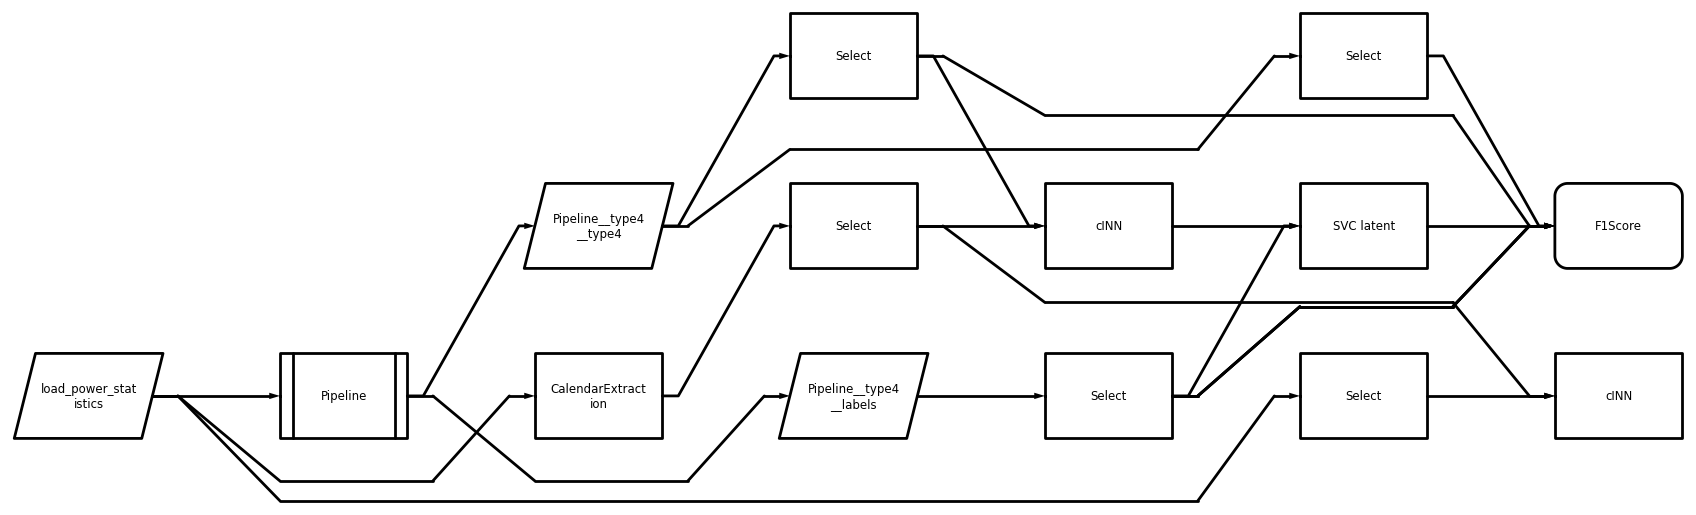

In [5]:
pipeline.draw(skip=["SampleModule", "StandardScaler", "SVC scaled", "SVC unscaled",
                    "FunctionModule"]).draw()

### Reading in the Data
To train and evaluate the pipeline we need data. In this case we:
* Automatically load the data and create a train and test split.
* We use a subset of hourly electricity load values for the state of Baden-Württemberg in Germany, taken from the Open Power Systems Data portal.

In [6]:
# Load data
data = load_elec_data()

# Create train and test splits
train_data = data[:6000]
test_data = data[6000:]

### Training the Pipeline
To train the pipeline, we simply call the __pipeline.train()__ method

In [7]:
results_train, summary_train = pipeline.train(train_data)

0, 0, 4782, 0.4918244779109955, 0.4909152090549469
1, 0, 4782, 0.43364691734313965, 0.4368680715560913
2, 0, 4782, 0.35638734698295593, 0.34679874777793884
3, 0, 4782, 0.2479807287454605, 0.23285464942455292
4, 0, 4782, 0.1259092539548874, 0.11635329574346542
5, 0, 4782, 0.02637346088886261, 0.010006621479988098
6, 0, 4782, -0.08510145545005798, -0.1020859032869339
7, 0, 4782, -0.22692297399044037, -0.25573521852493286
8, 0, 4782, -0.41821351647377014, -0.43690013885498047
9, 0, 4782, -0.5830318927764893, -0.6100487112998962
10, 0, 4782, -0.741443395614624, -0.76877760887146
11, 0, 4782, -0.8894462585449219, -0.9127373695373535
12, 0, 4782, -1.0079138278961182, -1.0354554653167725
13, 0, 4782, -1.120279312133789, -1.1361178159713745
14, 0, 4782, -1.2040088176727295, -1.2195334434509277
15, 0, 4782, -1.2826703786849976, -1.2882298231124878
16, 0, 4782, -1.3475030660629272, -1.3434362411499023
17, 0, 4782, -1.3724570274353027, -1.3928405046463013
18, 0, 4782, -1.4350751638412476, -1.4354

### Testing the pipeline
Finally we test the pipeline. This is achieved by calling the __pipeline.test()__ method on the test data set.

The F1 Score is printed to compare the accuracy of the three data representations

In [8]:
_, summary = pipeline.test(test_data, summary_formatter=SummaryJSON())
pd.DataFrame(summary["Summary"]["F1Score"])

,additional_information,results
svc_latent,,0.781308
svc_scaled,,0.727172
svc_unscaled,,0.727172


We hope this example helped you understand pyWATTS. If you have any questions feel free to contact us via [pywatts-team@iai.kit.edu](mailto:pywatts-team@iai.kit.edu)